<a href="https://colab.research.google.com/github/Trojan13/packgaabwir2022/blob/main/WIR_WiSe2223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-terrier

import pyterrier as pt
if not pt.started():
  pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [5]:
import os

dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './indices/cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
  indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
  index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno',))
  
else:
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
  
index = pt.IndexFactory.of(index_ref)

JavaException: JVM exception occurred: Could not load an index for ref ./indices/cord19/data.properties, even though IndexLoader org.terrier.structures.IndexOnDisk$DiskIndexLoader could support that type of index. It may be your ref had a wrong location; Terrier logs may have more information. java.lang.IllegalArgumentException

# Query Expansion Pipeline with Experiments

Sample tests. We add our pipeline later and compare to the baselines.

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)
#rm3_pipe = bm25 >> pt.rewrite.RM3(index) >> bm25


sdm.search("corona virus symptoms").iloc[0]["query"]


topics = dataset.get_topics(variant='title')
qrels = dataset.get_qrels()

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [1.69MB/s]
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [6.76MB/s]


In [ ]:
from pyterrier.measures import *
pt.Experiment(
  #these are our 3 pipelines
  [bm25,
   bm25 >> qe >> bm25,
  # rm3_pipe,
   sdm >> bm25],
  topics,
  qrels,
  eval_metrics=["map", "ndcg", "ndcg_cut_10@10","mrt"],
  # we declare BM25 as the baseline to obtain significance testing
  baseline=0,
  names=["BM25", "BM25 >> QE >> BM25","SDM >> BM25"]
)

,name,map,ndcg,ndcg_cut_10@10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10@10 +,ndcg_cut_10@10 -,ndcg_cut_10@10 p-value
0,BM25,0.206398,0.409228,0.605823,61.718247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 >> QE >> BM25,0.217422,0.427655,0.603619,120.395355,36.0,14.0,0.011971,33.0,17.0,0.000480,22.0,22.0,0.878674
2,SDM >> BM25,0.208315,0.410458,0.602792,82.903229,33.0,17.0,0.001081,31.0,19.0,0.018813,16.0,15.0,0.499504


# Query Expansion BERT Tests

Example from https://github.com/cmacdonald/pyterrier_bert

In [ ]:
!pip uninstall torch
!pip install  --upgrade git+https://github.com/cmacdonald/pyterrier_bert.git
from pyterrier_bert.bert4ir import *

trecdl = pt.datasets.get_dataset("trec-deep-learning-docs")


qrelsTest = dataset.get_qrels("test")
qrelsTrain = dataset.get_qrels("train")
#take 1000 topics for training
topicsTrain = dataset.get_topics("train").head(1000)
#take 50 topics for validation
topicsValid = dataset.get_topics("train").iloc[1001:1050]
#this one-liner removes topics from the test set that do not have relevant documents
topicsTest = dataset.get_topics("test").merge(qrelsTest[qrelsTest["label"] > 0][["qid"]].drop_duplicates())

# initial retrieval and QE baseline.
index = pt.IndexFactory.of(pt.IndexRef.of(index_ref))
DPH_br = pt.BatchRetrieve(index, controls={"wmodel" : "DPH"}, verbose=True, metadata=["docno", "body"])
DPH_br_qe = pt.BatchRetrieve(index, controls={"wmodel" : "DPH", "qe" : "on"}, verbose=True)



bertpipe = DPH_br >> BERTPipeline(max_valid_rank=20)
# training, this uses validation set to apply early stopping
bertpipe.fit(topicsTrain, qrelsTrain, topicsValid, qrelsTrain)

# testing performance
pt.pipelines.Experiment(topicsTest, 
                        [DPH_br, DPH_qe, bertpipe],
                        ['map', 'ndcg'], 
                        qrelsTest, 
                        names=["DPH", "DPH + QE", "DPH + BERT4IR"])

Found existing installation: torch 1.13.0+cu116
Uninstalling torch-1.13.0+cu116:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.8/dist-packages/caffe2/*
    /usr/local/lib/python3.8/dist-packages/functorch/*
    /usr/local/lib/python3.8/dist-packages/torch-1.13.0+cu116.dist-info/*
    /usr/local/lib/python3.8/dist-packages/torch/*
    /usr/local/lib/python3.8/dist-packages/torchgen/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.8/dist-packages/pip/_in

ModuleNotFoundError: ignored

In [ ]:


bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)
rm3_pipe = bm25 >> pt.rewrite.RM3(index) >> bm25


sdm.search("corona virus symptoms").iloc[0]["query"]


topics = dataset.get_topics(variant='title')
qrels = dataset.get_qrels()

from pyterrier.measures import *
pt.Experiment(
  #these are our 3 pipelines
  [bm25,
   bm25 >> qe >> bm25,
   rm3_pipe,
   sdm >> bm25,
   bertRanker],
  topics,
  qrels,
  eval_metrics=["map", "ndcg", "ndcg_cut_10@10","mrt","bert"],
  # we declare BM25 as the baseline to obtain significance testing
  baseline=0,
  names=["BM25", "BM25 >> QE >> BM25","bm25 >> RM3 >> bm25", "SDM >> BM25"]
)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [8.07MB/s]
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [1.29MB/s]


NameError: ignored

# RegEx Indices


Eventuell alt. Für neueres hier schauen:
https://nbviewer.org/github/roynirmal/queryExpWikiPassageQA/blob/master/word2vec/Local.ipynb


In [ ]:

import re

def tokenize(source):
  search = re.compile(r'^(.+?)(?:;(.+?))*?(?:#.+)?$', re.MULTILINE)
  return (token.strip().lower() for line in source.split('\n') if search.match(line)
    for token in line.split('#', 1)[0].split(';') if token)
          

In [ ]:
for token in tokenize('Parse email addresses, remove/replace unwanted characters'):
  print(repr(token))

'parse email addresses, remove/replace unwanted characters'


# SMART Stopwords
URL from Paper: https://jmlr.csail.mit.edu/papers/volume5/lewis04a/a11-smart-stop-list/english.stop

Working link from google:
http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/a11-smart-stop-list/english.stop

In [ ]:
from urllib.request import urlopen

smart_stop_words = urlopen('http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/a11-smart-stop-list/english.stop').read()
smart_stop_words = smart_stop_words.decode('utf-8')
smart_stop_words = smart_stop_words.split("\n")

 # Word2Vec from Gensim and train a wikipedia model for it

In [1]:
!pip install gensim
!pip install python-terrier==0.9.2
!pip install seaborn
from gensim.models import Word2Vec
import pyterrier as pt

In [ ]:

pt.init()
dataset = pt.get_dataset('irds:wikir/en78k/training')
index_ref = pt.IndexRef.of('./indices/wikir_en78k') # assumes you have already built an index
pipeline = pt.BatchRetrieve(index_ref, wmodel='BM25')
# (optionally other pipeline components)
pipeline(dataset.get_topics())

In [ ]:


from gensim.models import Word2Vec
mv_model = Word2Vec.load("data/word2vec.model")

queries = preprocess_queries(queries, augmented=True, mv_model=mv_model)
display(queries.head(5))

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

# Analysis of trec-covid dataset

In this chapter, we try to do an analysis of the metadata and tokens in the trec-covid dataset. It includes a description of the various fields present in the metadata and their statistics, such as the distribution of values and common patterns. The token analysis includes a description of the most frequent tokens in the dataset and their distribution, as well as an analysis of the vocabulary size and the presence of rare and out-of-vocabulary tokens.


## General information like topics/titles/qrels etc

In [4]:
import os
import pyterrier as pt
from IPython.display import display

if not pt.started():
  pt.init()



dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = 'F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\indices\cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
  indexer = pt.index.IterDictIndexer(pt_index_path + "/data.properties", blocks=True)
  index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno',))
  
else:
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
  
index = pt.IndexFactory.of(index_ref)



C:\Users\timm_\AppData\Local\Temp\ipykernel_21860\4267196705.py:15: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use kwargs in constructor instead
  index_ref = indexer.index(dataset.get_corpus_iter(),


KeyboardInterrupt: 

Exception ignored in: 'jnius.invoke0'
Traceback (most recent call last):
  File "jnius\jnius_proxy.pxi", line 82, in jnius.py_invoke0
  File "<frozen importlib._bootstrap>", line 404, in parent
KeyboardInterrupt: 


JavaException: JVM exception occurred: Cannot invoke "java.lang.Boolean.booleanValue()" because the return value of "java.lang.reflect.InvocationHandler.invoke(Object, java.lang.reflect.Method, Object[])" is null java.lang.NullPointerException

In [17]:
display(dataset.get_topics().columns)
display(dataset.get_topics())
display(dataset.get_qrels())


There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Index(['qid', 'title', 'description', 'narrative'], dtype='object')

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


,qid,title,description,narrative
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,5,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...
5,6,coronavirus test rapid testing,what types of rapid testing for Covid-19 have ...,Looking for studies identifying ways to diagno...
6,7,serological tests for coronavirus,are there serological tests that detect antibo...,Looking for assays that measure immune respons...
7,8,coronavirus under reporting,how has lack of testing availability led to un...,Looking for studies answering questions of imp...
8,9,coronavirus in Canada,how has COVID-19 affected Canada,"seeking data related to infections (confirm, s..."
9,10,coronavirus social distancing impact,has social distancing had an impact on slowing...,seeking specific information on studies that h...


,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
...,...,...,...,...
69313,50,zvop8bxh,2,5
69314,50,zwf26o63,1,5
69315,50,zwsvlnwe,0,5
69316,50,zxr01yln,1,5


In [20]:
import pandas as pd
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv')
metadata.columns

C:\Users\timm_\AppData\Local\Temp\ipykernel_8440\4281082646.py:2: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv')


Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

## Distribution of publish times of the sources

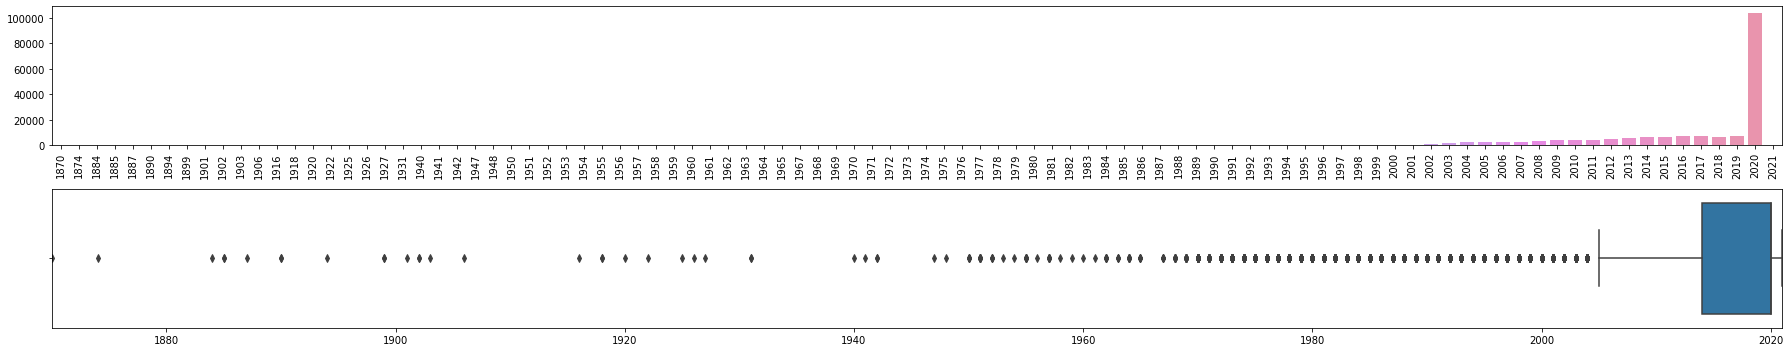

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

years = metadata["publish_time"]
years.dropna(inplace=True)

def getYear(dateString):
    strSplit = dateString.split('-')
    return int(strSplit[0])

years = list(map(getYear,years))
u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()
fig.savefig("./dates.png")

## Missing Data in Metadata

In [20]:
metadata.replace("", pd.NA, inplace=True)

for col in metadata:
  m = sum(metadata[col].isna())
  p = m / len(metadata) * 100
  print(f"{col:10} {m:5} ({p:.2f}%)")

cord_uid       0 (0.00%)
sha        112754 (58.57%)
source_x       0 (0.00%)
title         50 (0.03%)
doi        55274 (28.71%)
pmcid      105999 (55.06%)
pubmed_id  75205 (39.07%)
license        0 (0.00%)
abstract   54865 (28.50%)
publish_time    18 (0.01%)
authors     6477 (3.36%)
journal    10718 (5.57%)
mag_id     192509 (100.00%)
who_covidence_id 142184 (73.86%)
arxiv_id   190045 (98.72%)
pdf_json_files 112754 (58.57%)
pmc_json_files 129773 (67.41%)
url        41453 (21.53%)
s2_id      27865 (14.47%)


## Token Statistics

In [2]:
print(index.getCollectionStatistics())

Number of documents: 192509
Number of terms: 171154
Number of postings: 12375701
Number of fields: 3
Number of tokens: 19557770
Field names: [title, doi, abstract]
Positions:   true



 Add all tokens to the tokens array

In [3]:
tokens = []
for kv in index.getLexicon():
    tokens.append([kv.getKey(),	kv.getValue().getFrequency()])
tokens = sorted(tokens,key=lambda x: int(x[1]),reverse=True) #sorting

In [ ]:
print(tokens)

In [4]:
from collections import Counter

print("\n[Number of Tokens]")
print("Tokens:", len(tokens))

k = 10
bottom_k_tokens = tokens[-k:]
top_k_tokens = tokens[:k]
print(f"\n[Top {k} most common Tokens]")
print(f"Tokens: {', '.join([''.join(x[0]) for x in top_k_tokens])}")

print(f"\n[Bottom {k} least common Tokens]")
print(f"Tokens: {', '.join([''.join(x[0]) for x in bottom_k_tokens])}")



[Number of Tokens]
Tokens: 171154

[Top 10 most common Tokens]
Tokens: patient, 19, covid, 10, 2, infect, studi, diseas, 0, 1

[Bottom 10 least common Tokens]
Tokens: zytomegalieviru, zytopathisch, zytoplasma, zytoplasmabereich, zytoplasmamatrix, zytoskelett, zytostatisch, zytostatischen, zzfny, zzm002


This gives us a first insight into the functions and limitations of the used stemmers and the stop word list. 
The tokens 'cytostatic' and 'cytostatic' should actually be stemmed. Apparently the stemmer does not work well with german words.

The tokens '1' and '0' are not words and might have to be excluded first.

{'patient': 207768, '19': 207160, 'covid': 200606, '10': 168251, '2': 150533, 'infect': 140876, 'studi': 115534, 'diseas': 113187, '0': 109999, '1': 109655, 'sar': 88004, 'result': 87843, 'viru': 86453, 'cov': 80469, 'case': 74746, 'cell': 74186, '3': 72083, 'coronaviru': 71479, 'health': 69624, 'clinic': 68865, 'respiratori': 67791, 'pandem': 61906, 'effect': 61554, 'method': 58321, 'sever': 55701, '5': 55494, 'treatment': 54526, 'group': 54031, 'includ': 53465, 'time': 53366}


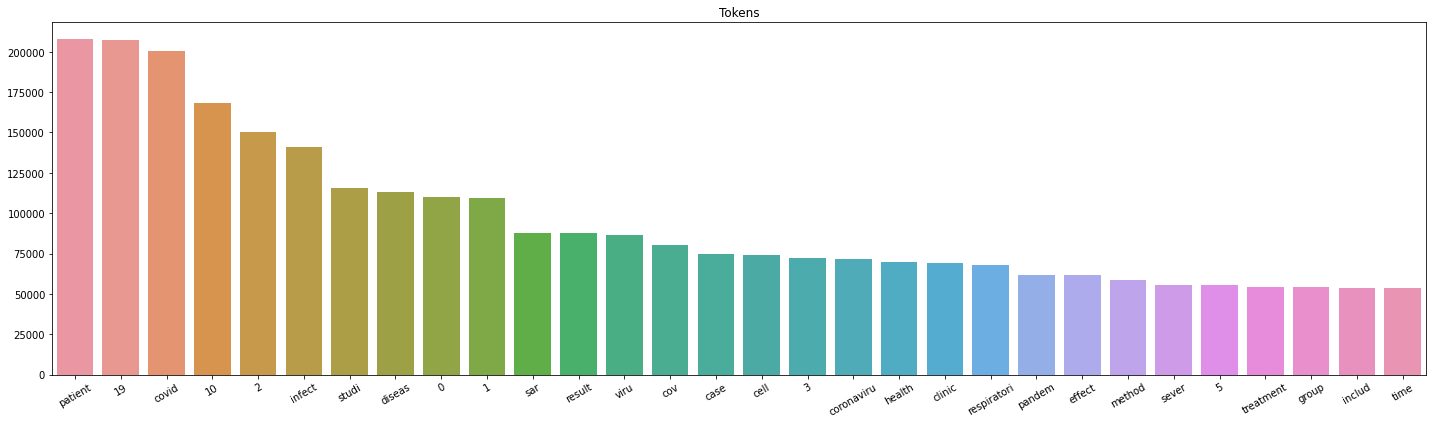

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_tokens = dict(tokens[:k])
print(common_tokens)
x_token = list(common_tokens.keys())
y_token = list(common_tokens.values())


fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(x=x_token, y=y_token, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax1.set_title("Tokens")
fig.tight_layout()

fig.savefig("./most_common.png")

# Ansatz von Timo Breuer
1. Anfrage an das System senden
2. Bekommen Top K Dokumente
3. Co-Autoren Analyse auf den Dokumenten
4. Die Dokumente mit relevanten Dokumenten von Co-Autoren erweitern
5. Gruppen aus den Dokumenten (3 Gruppen a 6, 3, 1)
6. Größte Gruppe auswählen 
7. Termset C, mit den Termen die Expansion machen (Ansatz: Titel von Referenzen anstatt Abstracts verwenden)
8. B01 Gewichtung zur Termordnung (Alternative: tfidf, bm25)
9. B01 Unterart von DFR (Divergence from Randomness) ist bei Pyterrier zu finden
10. Nicht entscheidend B01 zu Nutzen, sondern eine Art von DFR
11. Semantic Scholar für Referenzen für jeweilige Publikation (haben auch ne API, Anfrage senden und Referenz zurück bekommen).


In [ ]:
!pip install python-terrier==0.9.2
!pip install semanticscholar

import pyterrier as pt
from semanticscholar import SemanticScholar
import os

In [3]:
if not pt.started():
  pt.init()

dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = 'F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\indices\cord19'
pt_properties_path =os.path.join(pt_index_path + "/data.properties")


if not os.path.exists(pt_properties_path):
  indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
  indexer.setProperty("stopwords.filename", "F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\en.txt")
  index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno'))
  
else:
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
  
index = pt.IndexFactory.of(index_ref)

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]C:\Users\timm_\AppData\Local\Temp\ipykernel_21860\546312759.py:12: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use kwargs in constructor instead
  index_ref = indexer.index(dataset.get_corpus_iter(),


ValueError: Indexing meta key d not found in first document (keys ['title', 'doi', 'date', 'abstract', 'docno'])

In [1]:
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_doc2query.git
!pip install python-terrier==0.9.2
!pip install semanticscholar

import pyterrier as pt
from semanticscholar import SemanticScholar
import os

  Cloning https://github.com/terrierteam/pyterrier_doc2query.git to c:\users\timm_\appdata\local\temp\pip-req-build-p0zcizi0
  Resolved https://github.com/terrierteam/pyterrier_doc2query.git to commit 3449bcaf0727721d8d77c2524f0dc77dbbb77da0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/terrierteam/pyterrier_doc2query.git 'C:\Users\timm_\AppData\Local\Temp\pip-req-build-p0zcizi0'


In [3]:
import pyterrier_doc2query


if not pt.started():
    pt.init()

doc2query = pyterrier_doc2query.Doc2Query(append=True)
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = 'F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\indices\cord19'
pt_properties_path = os.path.join(pt_index_path + "/data.properties")


if not os.path.exists(pt_properties_path):
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
    indxer_pipe = doc2query >> indexer
    indxer_pipe.index(dataset.get_corpus_iter())
    indxer_pipe.setProperty(
        "stopwords.filename", "F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\en.txt")
    index_ref = indxer_pipe.index(dataset.get_corpus_iter(),
                                  fields=['title', 'doi', 'abstract'],
                                  meta=('docno',))

else:
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)


c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\pyterrier_doc2query\__init__.py:33: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

TypeError: ValueError() takes no keyword arguments

In [6]:
dir(dataset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_configure',
 '_describe_component',
 '_irds_id',
 '_irds_ref',
 'get_corpus',
 'get_corpus_iter',
 'get_corpus_lang',
 'get_index',
 'get_qrels',
 'get_results',
 'get_topics',
 'get_topics_lang',
 'get_topicsqrels',
 'info_url',
 'irds_ref']

In [7]:
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

pt.Experiment([tf_idf, bm25, pl2], eval_metrics=["map"])

NameError: name 'index' is not defined

In [10]:
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")

tf_idf.search("corona virus symptoms")


,qid,docid,docno,rank,score,query
0,1,191427,oykoiefo,0,22.343440,flower
1,1,141738,6pde41yc,1,21.042644,flower
2,1,68312,fc48z6ek,2,19.129528,flower
3,1,44606,sb7ybse0,3,18.948168,flower
4,1,190968,vbhlki5n,4,18.112783,flower
...,...,...,...,...,...,...
995,1,149113,jhklq4w3,995,0.511500,flower
996,1,147423,0b14ocyt,996,0.511324,flower
997,1,50937,3yk35rr0,997,0.511142,flower
998,1,136463,xl8zgg81,998,0.511134,flower


In [2]:
import pandas as pd
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv', low_memory=False)
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [3]:
author_dict = {}
for id, authors in zip(metadata['cord_uid'], metadata['authors']):
  author_dict[id] = authors
author_dict

{'ug7v899j': 'Madani, Tariq A; Al-Ghamdi, Aisha A',
 '02tnwd4m': 'Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E',
 'ejv2xln0': 'Crouch, Erika C',
 '2b73a28n': 'Fagan, Karen A; McMurtry, Ivan F; Rodman, David M',
 '9785vg6d': 'Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F',
 'zjufx4fo': 'Pasternak, Alexander O.; van den Born, Erwin; Spaan, Willy J.M.; Snijder, Eric J.',
 '5yhe786e': 'Alvarez, Gonzalo; Hébert, Paul C; Szick, Sharyn',
 '8zchiykl': 'Ball, Jonathan; Venn, Richard',
 '8qnrcgnk': 'Slebos, Dirk-Jan; Ryter, Stefan W; Choi, Augustine MK',
 'jg13scgo': 'Tsui, Fu-Chiang; Espino, Jeremy U.; Dato, Virginia M.; Gesteland, Per H.; Hutman, Judith; Wagner, Michael M.',
 '5tkvsudh': 'Ivanov, Ivaylo P.; Matsufuji, Senya; Murakami, Yasuko; Gesteland, Raymond F.; Atkins, John F.',
 '6lvn10f4': 'Shi, Stephanie T.; Huang, Peiyong; Li, Hsin-Pai; Lai, Michael M.C.',
 'tvxpckxo': 'Pridgeon, Julia W.; Geetha, Thangiah; Wooten, Marie W.',
 'mcuixluu': 'Ploubidou, Asp

In [2]:
import pyterrier as pt
from semanticscholar import SemanticScholar
import os

if not pt.started():
  pt.init()

dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = 'F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\indices\cord19'
pt_properties_path =os.path.join(pt_index_path + "/data.properties")


if not os.path.exists(pt_properties_path):
  indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
  # Using SMART Stopword ATTENTION This is a global setting.
  indexer.setProperty("stopwords.filename", "F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\en.txt")
  index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno',))
  
else:
  index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")
  
index = pt.IndexFactory.of(index_ref)

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]C:\Users\timm_\AppData\Local\Temp\ipykernel_28312\935086127.py:17: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use kwargs in constructor instead
  index_ref = indexer.index(dataset.get_corpus_iter(),
cord19/trec-covid documents:  42%|████▏     | 80472/192509 [00:43<00:59, 1881.30it/s]

22:36:07.164 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (uq2pbyjh) - further warnings are suppressed


cord19/trec-covid documents: 100%|██████████| 192509/192509 [01:33<00:00, 2063.10it/s]


22:36:57.451 [main] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.indexDocuments(BasicIndexer.java:270)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:377)
22:37:09.747 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 11 empty documents


In [3]:
index_count = 0


def prepare_index_path(indexName):
    global index_count
    index_count = index_count + 1
    index_path = indexName + str(index_count)

    if os.path.exists(index_path) & os.path.isdir(index_path):
        files = os.listdir(index_path)
        for file in files:
            file_name = index_path + '/' + file
            os.remove(file_name)
        os.rmdir(index_path)
    elif os.path.exists(index_path) & (not os.path.isdir(index_path)):
        os.rmove(index_path)

    return index_path


def build_index(docs):
    index_path_to_use = prepare_index_path("RELEVANCEIDX")
    indexer = pt.IterDictIndexer(
        './' + index_path_to_use, overwrite=True, blocks=True)
    indexer.setProperty(
        "stopwords.filename", "F:\Bibliotheken\Desktop\Skripte\packgaabwir2022\en.txt")
    index_created = indexer.index(docs["text"], docs["docno"], fields=['title', 'doi', 'abstract'],
                                  meta=('docno'))
    return index_created

In [6]:
import pandas as pd
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv', low_memory=False)
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [27]:


author_dict = {}
for id, authors in zip(metadata['cord_uid'], metadata['authors']):
    author_dict[id] = authors


'Daher, Valéria Barcelos; Soares Oliveira, Daniela Silva; Daher Júnior, Mauro Freitas; Júnior de Melo Fernandes, Edson; de Castro Guimarães, Valeriana; Bomtempo de Castro, João Victor; Moya, Marcela Ibanhes'

In [31]:
sch = SemanticScholar()
results = sch.search_author('Filip, Ioan')
results[0].papers

{'paperId': '02b61576d60ceb95cf8c15ac8e4ee250b30a72ce', 'externalIds': {'DOI': '10.37789/rjce.2022.13.1.3', 'CorpusId': 245044692}, 'url': 'https://www.semanticscholar.org/paper/02b61576d60ceb95cf8c15ac8e4ee250b30a72ce', 'title': 'Plastic materials incorporated in a pilot wastewater treatment plant', 'abstract': None, 'venue': 'Revista Romana de Inginerie Civila/Romanian Journal of Civil Engineering', 'year': 2021, 'referenceCount': 0, 'citationCount': 0, 'influentialCitationCount': 0, 'isOpenAccess': True, 'fieldsOfStudy': None, 's2FieldsOfStudy': [{'category': 'Engineering', 'source': 's2-fos-model'}], 'publicationTypes': None, 'publicationDate': '2021-12-10', 'journal': {'name': 'Revista Romana de Inginerie Civila/Romanian Journal of Civil Engineering'}, 'authors': [{'authorId': '2135645253', 'name': 'Ioana Filip'}]}

In [28]:
test_retrieval = pt.BatchRetrieve(index, wmodel='BM25')
test_results = test_retrieval.search("corona virus symptoms")
for row in test_results.itertuples():
    print(author_dict[row.docno])


Daher, Valéria Barcelos; Soares Oliveira, Daniela Silva; Daher Júnior, Mauro Freitas; Júnior de Melo Fernandes, Edson; de Castro Guimarães, Valeriana; Bomtempo de Castro, João Victor; Moya, Marcela Ibanhes
Findeklee, Sebastian; Morinello, Emanuela
Findeklee, Sebastian; Morinello, Emanuela
Ud-Dean, Minhaz; Filip, Ioan; Galanti, Marta; Birger, Ruthie; Comito, Devon; Freyer, Greg A; Ibrahim, Sadiat; Lane, Benjamin; Ligon, Chanel; Matienzo, Nelsa; Morita, Haruka; Shittu, Atinuke; Tagne, Eudosie; Dayan, Peter; Shaman, Jeffrey
Hase, Ryota; Kurita, Takashi; Muranaka, Emiri; Sasazawa, Hiroki; Mito, Haruki; Yano, Yudai
Hase, Ryota; Kurita, Takashi; Muranaka, Emiri; Sasazawa, Hiroki; Mito, Haruki; Yano, Yudai
Dinakaran, Damodharan; Manjunatha, Narayana; Naveen Kumar, Channaveerachari; Suresh, Bada Math
Ghoshal, Uday C.; Ghoshal, Ujjala; Dhiman, Radha Krishan
Dinakaran, Damodharan; Manjunatha, Narayana; Naveen Kumar, Channaveerachari; Suresh, Bada Math
Goothy, Sai Sailesh Kumar; Goothy, Srilatha;

In [ ]:

sch = SemanticScholar()

author_dict = {}
for id, authors in zip(metadata['cord_uid'], metadata['authors']):
    author_dict[id] = authors



# Add authors to retrieved docs
# Go through all docs split the authors by name
all_authors = doc['authors'].split('; ')
for author in all_authors:
    single_authors = author.split(', ')
    for single_author in single_authors:
        # ATTENTION Might need sleep(10) or sth because of API restrictions
        results = sch.search_author(single_author)
        if results:
            # Relevance? How to asses the relevance?
            # Build a new index with all the papers and assess relevance again
            indexref_author_papers = build_index(results[0].papers)
            ranked_author_papers = pt.BatchRetrieve(
                indexref_author_papers, wmodel='BM25')
